This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range. For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:

ID,item_cnt_month

0,0.5

1,0.5

2,0.5

3,0.5

etc.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

File descriptions

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('sales_train_v2.csv', parse_dates=['date'],
                    date_parser=lambda x: pd.to_datetime(x, format='%d.%m.%Y'))
test = pd.read_csv('test.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [3]:
def eda(data):
    print("---------------------------------------------------Data Head----------------------------------------------------")
    print(data.head(5))
    print("---------------------------------------------------Information--------------------------------------------------")
    print(data.info())
    print("---------------------------------------------------Data Types---------------------------------------------------")
    print(data.dtypes)
    print("---------------------------------------------------Missing value------------------------------------------------")
    print(data.isnull().sum())
    print("---------------------------------------------------Null value---------------------------------------------------")
    print(data.isna().sum())
    print("---------------------------------------------------Shape of Data------------------------------------------------")
    print(data.shape)
    
# eda(train)

In [4]:
print('Number of duplicates:', len(train[train.duplicated()]))

Number of duplicates: 6


In [5]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train = downcast_dtypes(train)
# print(train.info())

In [6]:
sales_by_item_id = train.pivot_table(index=['item_id'], values=['item_cnt_day'], columns='date_block_num',
                                     aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'

In [52]:
sales_by_item_id

,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\FadhelAdlansyah\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'Price')

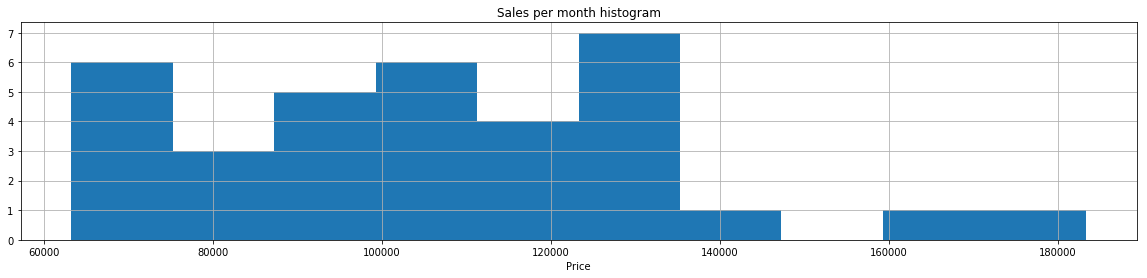

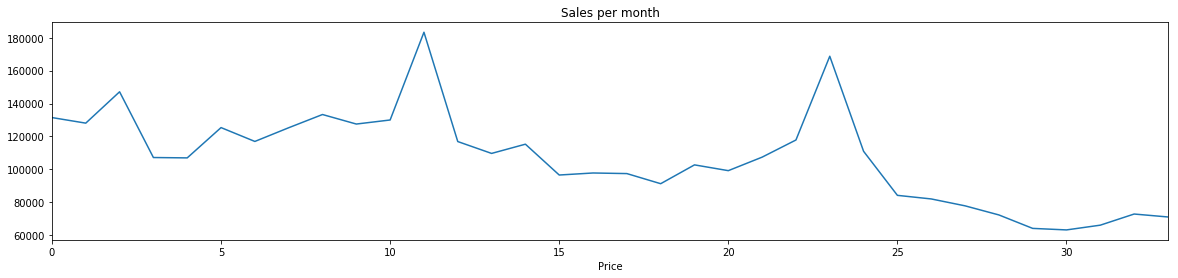

In [7]:
train.groupby('date_block_num').sum()['item_cnt_day'].hist(figsize = (20,4))
plt.title('Sales per month histogram')
plt.xlabel('Price')

plt.figure(figsize = (20,4))
sns.tsplot(train.groupby('date_block_num').sum()['item_cnt_day'])
plt.title('Sales per month')
plt.xlabel('Price')

In [9]:
outdated_items = sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0]
print('Outdated items:', len(outdated_items))

Outdated items: 12391


In [10]:
print('Outdated items in test set:', len(test[test['item_id'].isin(outdated_items['item_id'])]))

Outdated items in test set: 6888


Sale volume outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
Item price outliers: [11365  6066 13199]


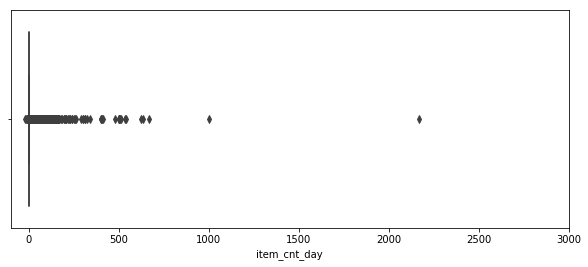

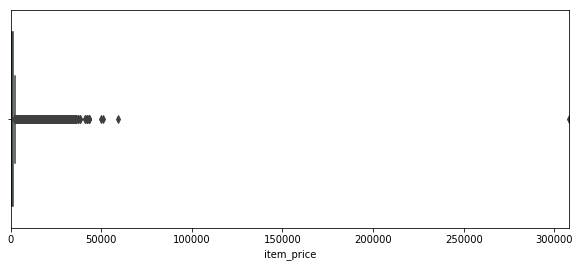

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train['item_cnt_day'])
print('Sale volume outliers:',train['item_id'][train['item_cnt_day']>500].unique())

plt.figure(figsize=(10,4))
plt.xlim(train['item_price'].min(), train['item_price'].max())
sns.boxplot(x=train['item_price'])
print('Item price outliers:',train['item_id'][train['item_price']>50000].unique())

In [12]:
sales_by_shop_id = train.pivot_table(index=['shop_id'],values=['item_cnt_day'], columns='date_block_num',
                                     aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

for i in range(6,34):
    print('Not exists in month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0].unique())

for i in range(6,28):
    print('Shop is outdated for month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1)==0].unique())


Not exists in month 6 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 7 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 8 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 9 [11 20 33 34 36 39 40 48 49]
Not exists in month 10 [11 20 33 34 36 39 40 48 49]
Not exists in month 11 [11 20 33 34 36 39 40 48]
Not exists in month 12 [11 20 33 34 36 39 40 48]
Not exists in month 13 [11 20 33 34 36 39 40 48]
Not exists in month 14 [11 20 33 34 36 48]
Not exists in month 15 [11 20 33 34 36]
Not exists in month 16 [11 20 33 34 36]
Not exists in month 17 [11 20 33 34 36]
Not exists in month 18 [11 20 33 36]
Not exists in month 19 [11 20 36]
Not exists in month 20 [11 20 36]
Not exists in month 21 [11 36]
Not exists in month 22 [11 36]
Not exists in month 23 [11 36]
Not exists in month 24 [11 36]
Not exists in month 25 [36]
Not exists in month 26 [36]
Not exists in month 27 [36]
Not exists in month 28 [36]
Not exists in month 29 [36]
Not exists in month 30 [36]
Not exists in month 31 [36]


In [13]:
print('Recently opened shop items:', len(test[test['shop_id']==36]))

Recently opened shop items: 5100


In [45]:
# cats = list(item_categories.item_category_name)

# for cats in range(1,8):
#     cats[ind] = 'Accessories'

# for ind in range(10,18):
#     l_cat[ind] = 'Consoles'

# for ind in range(18,25):
#     l_cat[ind] = 'Consoles Games'

# for ind in range(26,28):
#     l_cat[ind] = 'phone games'

# for ind in range(28,32):
#     l_cat[ind] = 'CD games'

# for ind in range(32,37):
#     l_cat[ind] = 'Card'

# for ind in range(37,43):
#     l_cat[ind] = 'Movie'

# for ind in range(43,55):
#     l_cat[ind] = 'Books'

# for ind in range(55,61):
#     l_cat[ind] = 'Music'

# for ind in range(61,73):
#     l_cat[ind] = 'Gifts'

# for ind in range(73,79):
#     l_cat[ind] = 'Soft'


# item_categories['cats'] = l_cat
# item_categories

,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Accessories
2,Аксессуары - PS3,2,Accessories
3,Аксессуары - PS4,3,Accessories
4,Аксессуары - PSP,4,Accessories
5,Аксессуары - PSVita,5,Accessories
6,Аксессуары - XBOX 360,6,Accessories
7,Аксессуары - XBOX ONE,7,Accessories
8,Билеты (Цифра),8,Билеты (Цифра)
9,Доставка товара,9,Доставка товара


In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int16
shop_id           int16
item_id           int16
item_price        float64
item_cnt_day      float32
dtypes: datetime64[ns](1), float32(1), float64(1), int16(3)
memory usage: 72.8 MB


In [68]:
sales_by_item_shop_id = train.pivot_table(index=['shop_id','item_id'], values=['item_cnt_day'], columns='date_block_num',
                                          aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_shop_id.columns = sales_by_item_shop_id.columns.droplevel()
sales_by_item_shop_id.columns.values[0] = 'shop_id'
sales_by_item_shop_id.columns.values[1] = 'item_id'

In [ ]:
# item_to_cat_df = items.merge(item_category[['item_category_id','cats']], how="inner", on="item_category_id")[['item_id','cats']]
# item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

# train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")

# # Encode Categories
# from sklearn import preprocessing

# number = preprocessing.LabelEncoder()
# train_cleaned_df[['cats']] = number.fit_transform(train_cleaned_df.cats)
# train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'cats'] + list(range(34))]
# train_cleaned_df.head()

In [74]:
sales_by_item_shop_id

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,36,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,40,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,42,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,43,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,49,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [76]:
item_categories

,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Accessories
2,Аксессуары - PS3,2,Accessories
3,Аксессуары - PS4,3,Accessories
4,Аксессуары - PSP,4,Accessories
5,Аксессуары - PSVita,5,Accessories
6,Аксессуары - XBOX 360,6,Accessories
7,Аксессуары - XBOX ONE,7,Accessories
8,Билеты (Цифра),8,Билеты (Цифра)
9,Доставка товара,9,Доставка товара


In [79]:
train = sales_by_item_shop_id.copy()

In [88]:
import xgboost as xgb

params = {'max_depth':10, 
          'subsample':1,
          'min_child_weight':0.5,
          'eta':0.3, 
          'num_round':1000, 
          'seed':1,
          'silent':0,
          'eval_metric':'rmse'}
num_round = 10
xgbtrain = xgb.DMatrix(train.iloc[:,(train.columns != 33)].values,
                       train.iloc[:, train.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(params, xgbtrain, num_round)
preds = bst.predict(xgb.DMatrix(train.iloc[:, (train.columns!=33)].values))


from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train.iloc[:, train.columns==33].values))
print(rmse)

1.2704505471191772


<Figure size 720x1440 with 0 Axes>

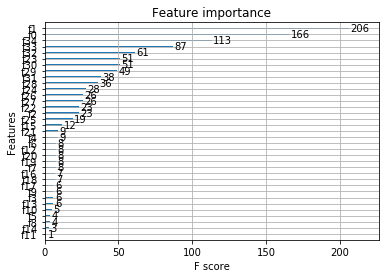

In [86]:
plt.figure(figsize=(10,20));
xgb.plot_importance(bst);

In [95]:
test = pd.read_csv('test.csv')

In [96]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [97]:
# test['shop_id'] = test.shop_id.astype('str')
# test['item_id'] = test.item_id.astype('str')

test = test.merge(train, how = "left", on = ["shop_id", "item_id"]).fillna(0)


,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,5,5039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0
6,6,5,5041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
7,7,5,5046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,8,5,5319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,2.0,3.0,2.0,2.0,4.0,3.0,2.0,3.0,0.0
9,9,5,5003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# Move to one month front
d = dict(zip(test.columns[3:],list(np.array(list(test.columns[3:])) - 1)))

test  = test.rename(d, axis = 1)

In [102]:
preds = bst.predict(xgb.DMatrix(test.iloc[:, (test.columns != 'ID') & (test.columns != -1)].values))

# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
submission = pd.DataFrame({'ID':test.ID,'item_cnt_month': preds })
submission.head()

,ID,item_cnt_month
0,0,0.418432
1,1,0.133549
2,2,0.699433
3,3,0.147550
4,4,0.133549


In [103]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 2 columns):
ID                214200 non-null int64
item_cnt_month    214200 non-null float64
dtypes: float64(1), int64(1)
memory usage: 4.9 MB


In [104]:
submission.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.252452
std,61834.358168,0.696671
min,0.000000,0.000000
25%,53549.750000,0.113565
50%,107099.500000,0.132294
75%,160649.250000,0.160077
max,214199.000000,20.000000


In [105]:
submission.to_csv('submission.csv',index=False)